In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
lr = 2e-4
z_dim = 100
batch_size = 128
image_size = 64
num_epochs = 5
channels_img = 1
features_discriminator = 64
features_generator = 64

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )


    def forward(self, x):
        return self.discriminator(x)


In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1,
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.generator(x)


In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    discriminator = Discriminator(in_channels, 8)
    initialize_weights(discriminator)
    assert discriminator(x).shape == (N, 1, 1, 1)
    generator = Generator(z_dim, in_channels, 8)
    initialize_weights(generator)
    z = torch.randn((N, z_dim, 1, 1))
    assert generator(z).shape == (N, in_channels, H, W)

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
    ]

)

In [8]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)

In [9]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
generator = Generator(z_dim, channels_img, features_generator).to(device)
discriminator = Discriminator(channels_img, features_discriminator).to(device)

In [11]:
initialize_weights(discriminator)
initialize_weights(generator)

In [12]:
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
loss = nn.BCELoss()

In [14]:
initial_noise = torch.randn(8, z_dim, 1, 1).to(device)

In [15]:
writer_fake = SummaryWriter(f"runs/DCGAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/DCGAN_MNIST/real")

In [16]:
generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [17]:
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [20]:
def show_images(fake_images, real_images, epoch):
    fake_images = fake_images.detach().cuda().numpy()
    real_images = real_images.detach().cuda().numpy()

    fig, ax = plt.subplots(2, 8, figsize=(15, 4))

    for i in range(8):
        ax[0, i].imshow(fake_images[i][0], cmap='gray', vmin=-1, vmax=1)
        ax[0, i].axis('off')
        ax[0, i].set_title("Fake")

        ax[1, i].imshow(real_images[i][0], cmap='gray', vmin=-1, vmax=1)
        ax[1, i].axis('off')
        ax[1, i].set_title("Real")

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.show()

Epoch [0/5]Loss D: 0.5272, Loss G: 1.0801


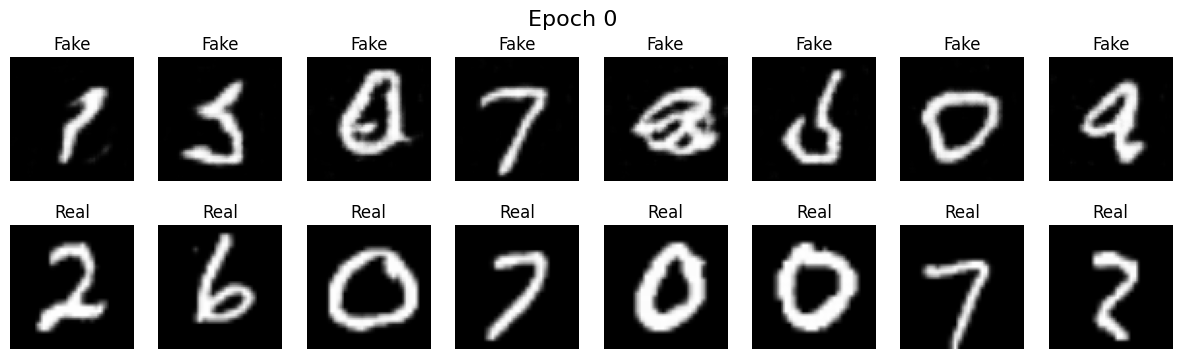

Epoch [1/5]Loss D: 0.1502, Loss G: 2.5137


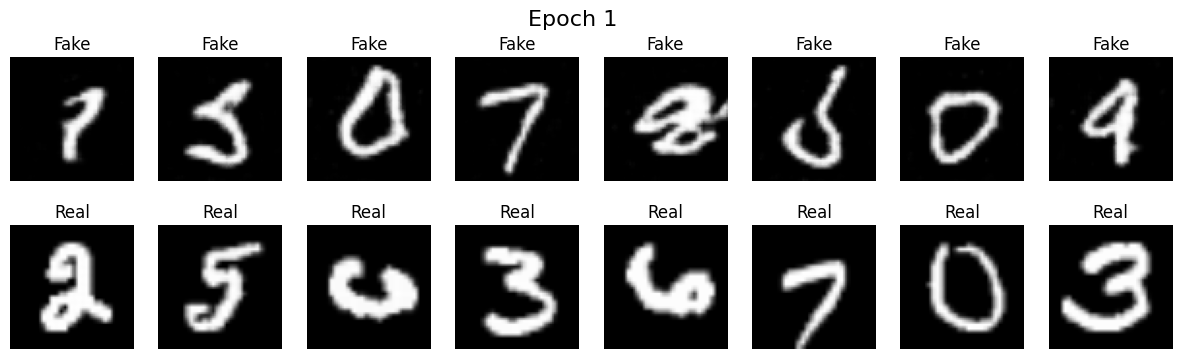

Epoch [2/5]Loss D: 0.2481, Loss G: 1.7540


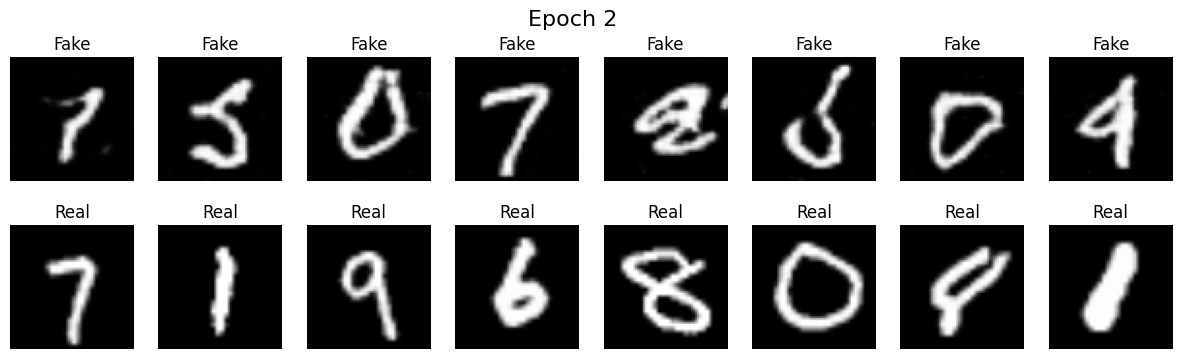

Epoch [3/5]Loss D: 0.0991, Loss G: 3.5732


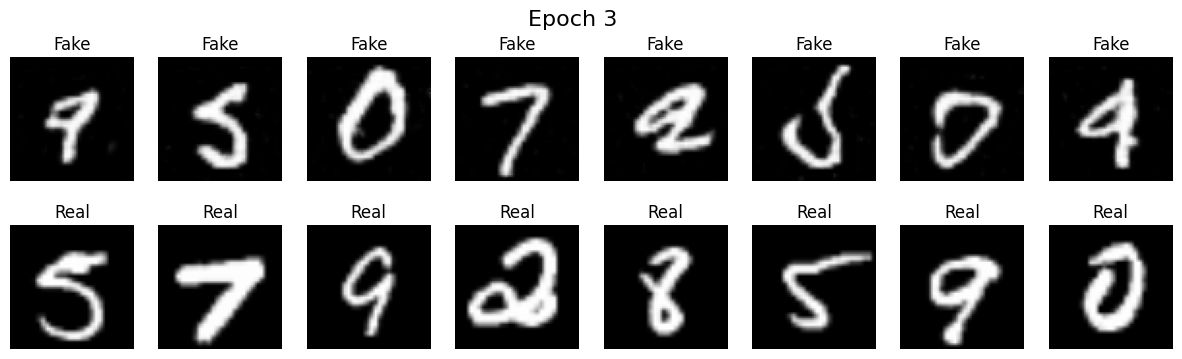

Epoch [4/5]Loss D: 0.7853, Loss G: 1.6337


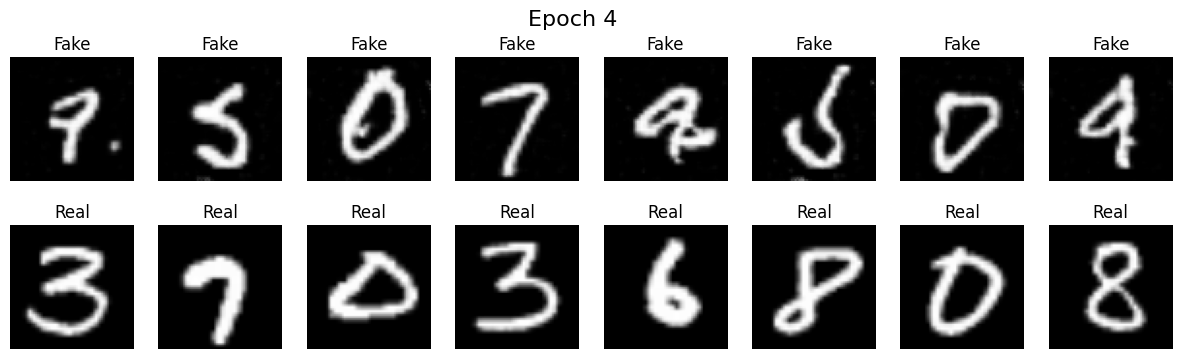

In [24]:
step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = generator(noise)

        disc_real = discriminator(real).reshape(-1)
        loss_disc_real = loss(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake).reshape(-1)
        loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        output = discriminator(fake).reshape(-1)
        loss_gen = loss(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}]"
                  f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fake = generator(initial_noise)


                img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
                img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)

                writer_fake.add_image(
                    "MNIST Fake Images", img_grid_fake, global_step=step
                )

                writer_real.add_image(
                    "MNIST Real Images", img_grid_real, global_step=step
                )

                step += 1

                show_images(fake[:8], real[:8], epoch)

In [ ]:
# The model is actually trained for 8 epochs